![banner](https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/banner.png?raw=true)

# Residual Vector Quantization

Residual Vector Quantization attempts to improve on the traditional Vector Quantization method that we learned about [here](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Generation/AutoEncoders/Intro%20to%20AutoEncoders/Vector_Quantized_Variational_AutoEncoders.ipynb)! This notebook is very quick and is just an extension of the previous VQVAE tutorial.

## Review: Vector Quantization

Vector Quantization is the process of taking some continuous signal (like audio, images, etc...) and mapping them to discrete codes. 

Lets look at KMeans again, as KMeans is a quantization method:

<div>
<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/kmeans.png?raw=true" width="400"/>
</div>

[Image Source](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html)

As we can see, in this trained KMeans model, all the points in each color coded location (the continuous point) is represented by the cluster centroid marked by the X. This has a a pro and a con:

- Pro: We have heavily reduced our data. Instead of having to store a large number of continuous values, we just store an index of which cluster centroid best represents it
- Con: We have lost our precision. Basically, all points in a region, is represented by the single cluster centroid. This means for every point we have some loss our our precision $\epsilon = x - q$ where $x$ was the original data and $q$ was its quantized cluster center. 

## Learning the Residuals
RVQs were originally a signal processing technique used for data compression (mainly audio) to solve the loss of precision that comes from quantizing. They do this by progressively building finer approximations by estimating residuals. 

<div>
<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/rvq.png?raw=true" width="800"/>
</div>

In our VQVAE implementation, we had a single codebook in our model. The Encoder would compress data down to the compressed space, we would select the code from our codebook that was closest to it, and then that code was sent to the decoder! The loss of precision was whatever is the difference between the output of the Encoder and the selected code.

In Residual Vector Quantization, we instead have multiple codebooks in sequence. As you can see above, we take our vector and quantize it like normal. But the key step is, instead of passing this quantized vector onto the decoder, we instead compute the residual, the difference between our quantized code and the output of the encoder. The residual is then passed to the next codebook which does the same thing. So we end up with something like this:

- Input: $X$ -> Codebook 1 -> $Q_1$
    - Residual 1 -> $R_1 = X - Q_1$
- Input: $R_1$ -> Codebook 2 -> $Q_2$
    - Residual 2 -> $R_2 = R_1 - Q_2$
- Input: $R_2$ -> Codebook 3 -> $Q_3$
    - Residual 1 -> $R_3 = R_2 - Q_3$
 
In the end our final "quantized" vector will just then be the sum of our codes, as each successive code of learning the residual.
- Final Quantized: $Q_1 + Q_2 + Q_3$

By stacking together our codebooks and learning the residuals in each successive codebook, we end up with more precision in our final code representation than would have been possible with just a single code. 

### A Visual with KMeans

![image](https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/rvq_process.gif?raw=true)

Here is an example of me applying KMeans, subtracting the centroid from my data and doing KMeans again, over and over. Notice how our estimation error continues to get closer to 0 the more times I repeat this!

### Lets Implement It!


In [51]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm

### Prep Dataset ###
tensor_transforms = transforms.Compose(
    [
        transforms.Resize((32,32)),
        transforms.ToTensor()
    ]
)

train_set = MNIST("../../../data/mnist/", train=True, transform=tensor_transforms)
test_set = MNIST("../../../data/mnist/", train=False, transform=tensor_transforms)

### Set Device ###
device = "cuda" if torch.cuda.is_available() else "cpu"

### Standard Vector Quantizer

The Vector Quantization process hasn't changed, we are just doing it multiple times instead of once! So lets just grab our vector quantizer from before and use it:

In [13]:
class VectorQuantizer(nn.Module):
    def __init__(self, codebook_size=1024, latent_dim=2):
        super().__init__()
        
        self.embedding = nn.Embedding(codebook_size, latent_dim)
        self.embedding.weight.data.uniform_(-1/codebook_size, 1/codebook_size)

        self.latent_dim = latent_dim
        self.codebook_size = codebook_size

    def forward(self, x):

        batch_size = x.shape[0]
        
        ### Distance btwn every Latent and Code: (L-C)**2 = (L**2 - 2LC + C**2 ) ###

        ### L2: [B, L] -> [B, 1]
        L2 = torch.sum(x**2, dim=1, keepdim=True)

        ### C2: [C, L] -> [C]
        C2 = torch.sum(self.embedding.weight**2, dim=1).unsqueeze(0)

        ### CL: [B,L]@[L,C] -> [B, C]
        CL = x@self.embedding.weight.t()

        ### [B, 1] - 2 * [B, C] + [C] -> [B, C]
        distances = L2 - 2*CL + C2
        
        ### Grab Closest Indexes, create matrix of corresponding vectors ###
        ### Closest: [B, 1]
        closest = torch.argmin(distances, dim=-1)

        ### Create Empty Quantized Latents Embedding ###
        # latents_idx: [B, C]
        quantized_latents_idx = torch.zeros(batch_size, self.codebook_size, device=x.device)

        ### Place a 1 at the Indexes for each sample for the codebook we want ###
        batch_idx = torch.arange(batch_size)
        quantized_latents_idx[batch_idx,closest] = 1

        ### Matrix Multiplication to Grab Indexed Latents from Embeddings ###

        # quantized_latents: [B, C] @ [C, L] -> [B, L]
        quantized_latents = quantized_latents_idx @ self.embedding.weight

        return quantized_latents, closest 

vq = VectorQuantizer(codebook_size=512,latent_dim=8)
rand = torch.randn(1024,8)
vq(rand)

(tensor([[-1.7819e-03, -1.0195e-03, -1.8394e-03,  ..., -1.2966e-03,
          -1.2748e-03, -1.8833e-03],
         [-1.6077e-03,  7.9818e-04, -1.7221e-03,  ..., -1.8285e-03,
           1.7109e-04, -1.5133e-03],
         [-6.9525e-05,  1.1603e-03,  1.6527e-03,  ...,  1.5817e-03,
          -6.7006e-04,  5.8776e-05],
         ...,
         [ 8.8236e-04,  8.2889e-04,  1.5263e-03,  ..., -1.3442e-03,
           1.1514e-03, -1.6067e-03],
         [ 1.4004e-03,  1.8573e-03, -9.3832e-04,  ..., -1.8154e-03,
          -1.8962e-03,  1.0471e-03],
         [-1.7819e-03, -1.0195e-03, -1.8394e-03,  ..., -1.2966e-03,
          -1.2748e-03, -1.8833e-03]], grad_fn=<MmBackward0>),
 tensor([  8, 325, 171,  ...,  21, 441,   8]))

### Lets Implement a Linear RVQ Now!

Nothing is really changing here from our VQVAE, but there are two key ideas:

1) We have multiple VQ codebooks now
2) When we compute the residual between our encoder output $z$ and our codes $q$, we will do $z - q$. The problem? WE CANT!! The entire purpose of the VQVAE loss (codebook and commitment) with our passthrough gradients was that getting from $z$ to $q$ was not a differentiable process. Therefore, we cant just subtract $q$ from $z$ to compute our residual as we can't backprop through that operation. So instead, we will do our residual computed as $z - sg(q)$, treating our quantized as a constant, because we are afterall sending the residual forward to be quantized again

In [60]:
class LinearResidualVectorQuantizedVAE(nn.Module):
    def __init__(self, latent_dim=2, codebook_size=64, num_codebooks=4):
        super().__init__()

        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(32*32, 128),
            nn.ReLU(),
            nn.Linear(128, 64), 
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        
        #############################################################
        ###  Stack of Codebooks for Residual Vector Quantization  ###
        self.rvq = nn.ModuleList(
            [
                VectorQuantizer(codebook_size, latent_dim) for _ in range(num_codebooks)
            ]
        )
        
        #############################################################
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 32*32),
            nn.Sigmoid()
        )


    def forward_enc(self, x):

        x = self.encoder(x)
    
        return x

    def quantize(self, z, return_code_idx_only=False):
        
        #############################################
        ## Quantize the Latent Space Representation #

        codebook_losses = 0
        commitment_losses = 0
        quantized_codes = []
        code_indexes = []
        final_quantized = torch.zeros_like(z)
        
        for quantizer in self.rvq:

            ### Get Closest Codes ###
            codes, code_idx = quantizer(z)

            ### Store code Indexes ###
            code_indexes.append(code_idx)

            ### Compute VQ Loss ###
            codebook_loss = torch.mean((codes - z.detach())**2)
            commitment_loss = torch.mean((codes.detach() - z)**2)

            codebook_losses += codebook_loss
            commitment_losses += commitment_loss

            ### Straight Through Gradients ###
            codes = z + (codes - z).detach()

            ### Accumulate Codes for Final Quantized ###
            final_quantized = final_quantized + codes

            ### Store Quantized ###
            quantized_codes.append(codes)
            
            ### Update Z to be the Residual Error (But dont compute gradients) ###
            z = z - codes.detach()
            
        #############################################
       
        if return_code_idx_only:
            return torch.stack(code_indexes, dim=-1)
        else:
            return final_quantized, codebook_losses, commitment_losses

    def forward_dec(self, x):
        codes, codebook_losses, commitment_losses = self.quantize(x)
        decoded = self.decoder(codes)
        return codes, decoded, codebook_losses, commitment_losses

    @torch.no_grad()
    def get_codes(self, x):

        ### Get the Code Indexes for A Batch of Images ###
        x = x.flatten(1)
        x = self.encoder(x)
        code_idx = self.quantize(x, return_code_idx_only=True)
        return code_idx

    @torch.no_grad()
    def decode_codes(self, code_idx):

        ### Create Empty Tensor to Accumulate RVQ Codes into ###
        batch_size = code_idx.shape[0]
        rvq_codes = torch.zeros(batch_size, self.latent_dim, device=code_idx.device)

        ### Loop Through Quantizer and Grab the Correct Codes ###
        for idx, quantizer in enumerate(self.rvq):
            q_codes = code_idx[:, idx]

            ### Accumulate the Codes into our rvq codes ###
            quantized_embeddings = quantizer.embedding(q_codes)
            rvq_codes += quantized_embeddings

        ### Decode Back to Image Space ###
        decoded = self.decoder(rvq_codes)

        decoded = decoded.reshape(batch_size, 1, 32, 32)

        return decoded
        

    def forward(self, x):
        
        batch, channels, height, width = x.shape
        
        ### Flatten Image to Vector ###
        x = x.flatten(1)

        ### Pass Through Encoder ###
        latents = self.forward_enc(x)
        
        ### Pass Sampled Data Through Decoder ###
        quantized_latents, decoded, codebook_loss, commitment_loss = self.forward_dec(latents)

        ### Put Decoded Image Back to Original Shape ###
        decoded = decoded.reshape(batch, channels, height, width)

        return latents, quantized_latents, decoded, codebook_loss, commitment_loss

model = LinearResidualVectorQuantizedVAE()

rand = torch.randn(2,1,32,32)
codes = model.get_codes(rand)
model.decode_codes(codes).shape

torch.Size([2, 1, 32, 32])

In [61]:
def train(model,
          train_set,
          test_set,
          batch_size, 
          training_iterations, 
          evaluation_iterations):
        
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = model.to(device)
    
    trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
    testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)

    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    train_loss = []
    evaluation_loss = []
    train_losses = []
    evaluation_losses = []

    pbar = tqdm(range(training_iterations))
    
    train = True
    
    step_counter = 0
    while train:

        for images, labels in trainloader:
            
            images = images.to(device)

            encoded, quantized_encoded, decoded, codebook_loss, commitment_loss = model(images)
            reconstruction_loss = torch.mean((images-decoded)**2)
            loss = reconstruction_loss + codebook_loss +  0.25*commitment_loss
            
            train_loss.append(loss.item())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if step_counter % evaluation_iterations == 0:
                
                model.eval()

                for images, labels in testloader:

                    images = images.to(device)

                    encoded, quantized_encoded, decoded, codebook_loss, commitment_loss = model(images)
                    reconstruction_loss = torch.mean((images-decoded)**2) 
                    loss = reconstruction_loss + codebook_loss +  0.25*commitment_loss
                    
                    evaluation_loss.append(loss.item())
                    
                train_loss = np.mean(train_loss)
                evaluation_loss = np.mean(evaluation_loss)

                train_losses.append(train_loss)
                evaluation_losses.append(evaluation_loss)
                
                train_loss = []
                evaluation_loss = []

                model.train()

            step_counter += 1
            pbar.update(1)
           
            
            if step_counter >= training_iterations:
                print("Completed Training!")
                train = False
                break

    print("Final Training Loss", train_losses[-1])
    print("Final Evaluation Loss", evaluation_losses[-1])
    
    return model, train_losses, evaluation_losses

In [62]:
linear_rvq = LinearResidualVectorQuantizedVAE()
linear_ae, train_losses, evaluation_losses = train(linear_rvq,
                                                   train_set=train_set,
                                                   test_set=test_set,
                                                   batch_size=64,
                                                   training_iterations=25000,
                                                   evaluation_iterations=250)

  0%|          | 0/25000 [00:00<?, ?it/s]

Completed Training!
Final Training Loss 0.03157085467875004
Final Evaluation Loss 0.03197674519696813


### Let Test a Generation 

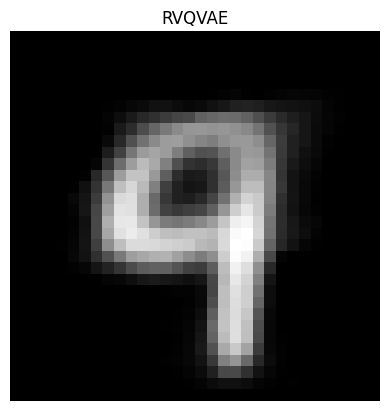

In [63]:
generated_index = 150
image, label = test_set[generated_index]
image = image.unsqueeze(0).to(device)

_,_, rvqvae_reconstructed, *_ = linear_rvq(image)

image = image.to("cpu")
rvqvae_reconstructed = rvqvae_reconstructed.to("cpu").detach().numpy()

plt.imshow(rvqvae_reconstructed.squeeze(), cmap="gray")
plt.title("RVQVAE")
plt.axis("off")
plt.show()

### Getting Codes 

The coolest part of VQVAE and RVQ is that instead of storing some high dimensional codevectors, we can just store the indexes to them. Then during inference we can just load our model up and grab the codes at those indexes! This is a huge space saver. 

Imagine you are storing photos like Google Photos on a server. Would you rather store all the RGB values of high res images, or compress them and just store the quantized indexes?

Code Indexes:
tensor([[10, 60, 58, 46]], device='cuda:0')


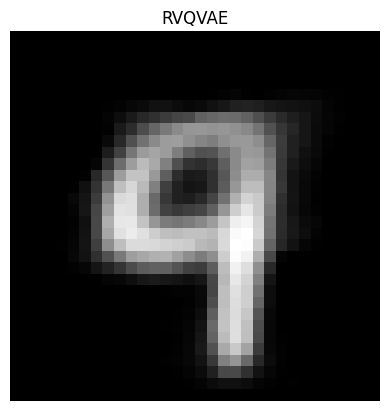

In [66]:
generated_index = 150
image, label = test_set[generated_index]
image = image.unsqueeze(0).to(device)

### Get Codes ###
code_idx = linear_rvq.get_codes(image)
print("Code Indexes:")
print(code_idx)

### Decode Codes ###
decoded = linear_rvq.decode_codes(code_idx)

plt.imshow(rvqvae_reconstructed.squeeze(), cmap="gray")
plt.title("RVQVAE")
plt.axis("off")
plt.show()


### Thats It!

So this was very quick, and just a minor extension of the VQVAE. On a dataset like MNIST we don't see any major gains, but this is a crucial technique used on things like Audio Codecs like EnCodec, we will come back to this later when we implement that!